<a href="https://colab.research.google.com/github/dwi11harsh/autograd/blob/main/autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Building Micrograd</h1>
This Notebook explains the <a href="https://youtu.be/VMj-3S1tku0?si=9F4b9_SziPxp53SM">The spelled-out intro to neural networks and backpropagation: building micrograd</a> by <a href="https://karpathy.ai/">Andrej Karpathy</a>.<br>


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
# a simple function that takes in a single scalar `x` and returns a single scalar `y`
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(3)

20

In [5]:
# now creating some x values
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [6]:
# and now some y values using the function described above
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

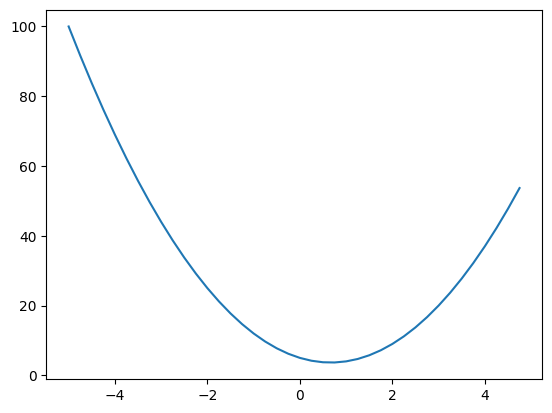

In [7]:
# plotting these xs and ys
plt.plot(xs, ys)

In [8]:
# Now, (from calculus class) a derivative of a function at any point is the measure of how sensitive the function is at that point
# if we slightly bump up (or down) the value of the argument which we are passing. This change is offcourse infinitely small (close to 0).
# lets take a very small `h`
h = 0.001
x = 3.0
(f(x+h)-f(x))/h

14.00300000000243

In [9]:
# now if we calculate by hand then derivative of our function would be 6x-4 and equating it with 0 we get x=2/3
# so at x = 2/3 the derivative is not very responsive to infinitely small changes in h

In [10]:
h=0.000001
x=2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [11]:
# now writing a small equation to understand the effect of nudging any of its variables
a = 2.0
b = -3.0
c = 10.0

# equation
d = a*b + c
d

4.0

In [12]:
# nudging each of the variables to see how much each of them affect this value (4.0)

h = 0.0001

# nudging `a`
a1 = a + h

d1 = a1*b + c

# now wile finding the differential w.r.t a we expect a negative slope coz when we differentiate the equation w.r.t `a` we get b and it is negative
# so we should be left with a value close to b
(d1-d)/h

-3.000000000010772

In [13]:
# nudging `b`
b1 = b + h

d2 = a*b1 + c

# now wile finding the differential w.r.t `b` we expect a value close to `a`
(d2-d)/h

2.0000000000042206

In [14]:
# nudging `c`
c1 = c + h

d3 = a*b + c1

# now wile finding the differential w.r.t `c` we expect a slope of one as there would be just 1 left while partially differentiating original equation w.r.t. c
(d3-d)/h

0.9999999999976694

In [15]:
# so now we have some sense of what this derivative function actually represents

In [16]:
# now lets get cookin
# first we need to build a data structure which can store our neural nets

class Value:
  def __init__(self, data):   # this will be used to initialize any variable
    self.data = data

  def __repr__(self):         # repr allows us to print a better looking expression or else we get something we wont be expecting
    return f"Value(data={self.data})"

  def __add__(self, other):
    return Value(self.data + other.data)    # internally it calculates a.__add__(b)

  def __mul__(self, other):
    return Value(self.data * other.data)

In [17]:
# now that we have our data structure, lets try to recreate the above expression with this data structure

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

# and now we should be able to recreate the above expression

a*b + c # this calls the following expression internally
# (a.__mul__(b)).__add__(c)

Value(data=4.0)

In [18]:
# since we already have the basic data structure, what we need now is to have a method which would tell us the values which produced the newer values

# for this purpose we add an empty tuple during initialization to this data structure which then keeps record of the initial values used to create the newer values
class Value:
  def __init__(self, data, _children=()):
    self.data = data
    self._prev = set(_children) # now inside the class we are instead maintaining a set (just for efficiency purpose, dont fuss about it)

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other))
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other))
    return out


a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
d

Value(data=4.0)

In [19]:
# but the amazing thing that we can do now is know which values contributed to output d
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [31]:
# and the last thing we need is to also maintain what expressions contributed to this end value
class Value:
  def __init__(self, data, _children=(), _op='', _label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self._label = _label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out


a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
e = a*b
e._label='e'
d = e + c
d._label='d'
f = Value(-2.0, _label='f')
L = d*f
L._label='L'
L

Value(data=-8.0)

In [32]:
# and now we can also know the expression which was performed to get the output value
d._op, d._prev, d

('+', {Value(data=-6.0), Value(data=10.0)}, Value(data=4.0))

In [33]:
# so this tells us that a + op was performed on Value -6.0 and Value 10.0 to get the value 4

In [34]:
# we know that in neurals, these expressions could get really big, so, we need a way to easily visualize our data structure and for that we are going to use graphviz
from graphviz import Digraph

# getting all the nodes and edges by tracing the data structure
def trace(root):
  # building a set of all the nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)

  return nodes, edges

# generating the graph
def draw_graph(root):
  graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes,edges = trace(root)

  for node in nodes:
    uid = str(id(node))
    # for any value in graph, create a rectangular node for it
    graph.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (node._label, node.data, node.grad ), shape='record')

    if node._op:
      # if this value is a result of some operation, create an operation node for it
      graph.node(name = uid + node._op, label = node._op)
      # and connect this node to it
      graph.edge(uid + node._op, uid)

  for n1, n2 in edges:
    # connect n1 to the operation node of n2
    graph.edge(str(id(n1)), str(id(n2)) + n2._op)

  return graph

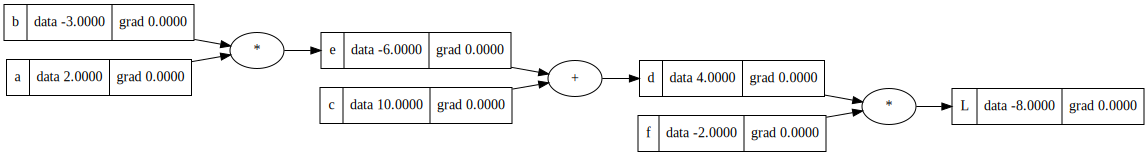

In [35]:
draw_graph(L)

In [ ]:
#